# CoDaS-HEP Columnar Data Analysis, part 2

This is the second of four notebooks on [columnar data analysis](https://indico.cern.ch/event/1287965/timetable/#41-columnar-data-analysis), presented at CoDaS-HEP at 13:30pm on July 20, 2023 by Jim Pivarski and Ioana Ifrim.

See the [GitHub repo](https://github.com/ioanaif/columnar-data-analysis-codas-hep-2023) for instructions on how to run it.

<br><br><br><br><br>

## From ROOT files into arrays

Physics data are in ROOT files. For columnar analysis, we'll need to get the data into arrays.

In [2]:
import ROOT

Welcome to JupyROOT 6.28/00


In [3]:
rdf = ROOT.RDataFrame("Events", "../data/SMHiggsToZZTo4L.root")

In [4]:
rdf.AsNumpy(["MET_pt", "MET_phi"])

{'MET_pt': ndarray([21.92993 , 16.972134, 19.061464, ..., 17.671701, 23.999083,
          12.943779], dtype=float32),
 'MET_phi': ndarray([-2.7301223,  2.8669462, -2.1664631, ...,  1.8889483, -1.973488 ,
           1.6512431], dtype=float32)}

<br><br><br><br><br>

But for variable-length data, such as particle quantities in events with arbitrarily many particles, the NumPy array has `dtype=object`.

In [5]:
muon_quantities = rdf.AsNumpy(["Muon_pt", "Muon_phi"])
muon_quantities

{'Muon_pt': ndarray([<cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0e8000000>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0e8000040>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0e8000080>,
          ...,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0e924f080>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0e924f0c0>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0e924f100>],
         dtype=object),
 'Muon_phi': ndarray([<cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0ea000000>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0ea000040>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0ea000080>,
          ...,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0eb24f080>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0eb24f0c0>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0eb24f100>],
         dtype=object)}

<br><br><br><br><br>

NumPy `dtype=object` arrays are essentially lists: every element is a Python object and NumPy does not know the internal structure.

On the one hand, this limits speed of calculation (notice the units):

In [6]:
import numpy as np

numeric_array = np.arange(500000, dtype=np.int64)
python_objects = np.array(range(500000), dtype=object)

In [7]:
%%timeit

numeric_array**2

145 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%%timeit

python_objects**2

101 ms ± 462 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


And on the other hand, it limits expressiveness:

In [9]:
numeric_array = np.empty((2, 2, 3), dtype=np.int64)
python_objects = np.empty(2, dtype=object)

numeric_array[:] = [[[1, 2, 3], [4, 5, 6]], [[10, 20, 30], [40, 50, 60]]]
python_objects[:] = [[[1, 2, 3], [4, 5, 6]], [[10, 20, 30], [40, 50, 60]]]

In [10]:
numeric_array[:, :, 1:]    # drop first element from innermost dimension

array([[[ 2,  3],
        [ 5,  6]],

       [[20, 30],
        [50, 60]]])

In [11]:
python_objects[:, :, 1:]   # can't manipulate anything past the first dimension

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

<br><br><br><br><br>

Thus, to compute $p_x$ and $p_y$ from muon $p_T$ and $\phi$ in Python, we'd have to drop down into imperative or list comprehensions (functional):

In [12]:
all_pt, all_phi = muon_quantities["Muon_pt"], muon_quantities["Muon_phi"]

all_px = np.array([[pt * np.cos(phi) for pt, phi in zip(event_pt, event_phi)] for event_pt, event_phi in zip(all_pt, all_phi)], dtype=object)
all_py = np.array([[pt * np.sin(phi) for pt, phi in zip(event_pt, event_phi)] for event_pt, event_phi in zip(all_pt, all_phi)], dtype=object)

all_px, all_py

(array([list([-62.09642131826239, 19.5441283607252, 2.05475040026448]),
        list([]), list([]), ...,
        list([2.3748022786066803, 3.9543648339704807, 3.018615575574287, 2.254885007906879]),
        list([]), list([])], dtype=object),
 array([list([10.888704252275756, -32.729005959017954, 3.4885342087314886]),
        list([]), list([]), ...,
        list([3.6040879736688813, 1.8335333778519878, 4.755512408592984, 4.181554816344941]),
        list([]), list([])], dtype=object))

<br><br><br><br><br>

However, if we instead read the file with Uproot (to be described later),

In [13]:
import uproot

In [14]:
with uproot.open("../data/SMHiggsToZZTo4L.root:Events") as events:
    muon_quantities2 = events.arrays(["Muon_pt", "Muon_phi"])

muon_quantities2.show()

[{Muon_pt: [63, 38.1, 4.05], Muon_phi: [2.97, ..., 1.04]},
 {Muon_pt: [], Muon_phi: []},
 {Muon_pt: [], Muon_phi: []},
 {Muon_pt: [54.3, 23.5, ..., 8.39, 3.49], Muon_phi: [...]},
 {Muon_pt: [], Muon_phi: []},
 {Muon_pt: [38.5, 47], Muon_phi: [2.05, -1.15]},
 {Muon_pt: [4.45], Muon_phi: [1.12]},
 {Muon_pt: [], Muon_phi: []},
 {Muon_pt: [], Muon_phi: []},
 {Muon_pt: [], Muon_phi: []},
 ...,
 {Muon_pt: [37.2, 50.1], Muon_phi: [-0.875, 2.65]},
 {Muon_pt: [43.2, 24], Muon_phi: [-1.3, 1.38]},
 {Muon_pt: [24.2, 79.5], Muon_phi: [-0.997, 2.51]},
 {Muon_pt: [], Muon_phi: []},
 {Muon_pt: [9.81, 25.5], Muon_phi: [1.66, -3.09]},
 {Muon_pt: [32.6, 43.1], Muon_phi: [-0.981, 2.27]},
 {Muon_pt: [4.32, 4.36, 5.63, 4.75], Muon_phi: [0.988, ...]},
 {Muon_pt: [], Muon_phi: []},
 {Muon_pt: [], Muon_phi: []}]


Operations on these Awkward Arrays (to be described later) can be expressed in an array-oriented way:

In [15]:
all_pt, all_phi = muon_quantities2["Muon_pt"], muon_quantities2["Muon_phi"]

all_px = all_pt * np.cos(all_phi)
all_py = all_pt * np.sin(all_phi)

all_px, all_py

(<Array [[-62.1, 19.5, 2.05], [], [], ..., [], []] type='299973 * var * float32'>,
 <Array [[10.9, -32.7, 3.49], [], [], ..., [], []] type='299973 * var * float32'>)

<br><br><br><br><br>

To be fair, that's not how RDataFrame is _supposed_ to be used: it's a functional programming framework that takes functions as strings of C++ code (which it compiles).

The `ROOT::VecOps` library presents an array-oriented style _per event_.

In [16]:
(
    rdf.Define("px", "Muon_pt * ROOT::VecOps::cos(Muon_phi)")
       .Define("py", "Muon_pt * ROOT::VecOps::sin(Muon_phi)")
       .AsNumpy(["px", "py"])
)

{'px': ndarray([<cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0d8000000>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0d8000040>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0d8000080>,
          ...,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0d924f080>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0d924f0c0>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0d924f100>],
         dtype=object),
 'py': ndarray([<cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0da000000>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0da000040>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0da000080>,
          ...,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0db24f080>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0db24f0c0>,
          <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x7fd0db24f100>],
         dtype=object)}

<br><br><br><br><br>

## Tools from Scikit-HEP

<img src="../img/scikit-hep-logo.svg" width="300">

Scikit-HEP is an umbrella organization for particle physics software in Python.

See [scikit-hep.org](https://scikit-hep.org/) for more information.

<br><br><br><br><br>

### Uproot

<img src="../img/uproot-logo.svg" width="300">

Uproot is a reimplementation of ROOT file I/O in Python.

See [uproot.readthedocs.io](https://uproot.readthedocs.io/) for tutorials and reference documentation.

<img src="../img/abstraction-layers.svg" width="800">

<br><br><br><br><br>

ROOT files can contain standalone objects, such as histograms, and tables of data ("TTrees") whose columns are arrays ("TBranches").

As a low-level detail, ranges of entries in the arrays can only be read in granular units ("TBaskets").

<img src="../img/terminology.svg" width="700">

Uproot reads standalone objects, including TTree metadata, in slow, imperative Python.

It reads, decompresses, and interprets TBranch arrays in fast, array-oriented NumPy.

<br><br><br><br><br>

Here's an example of how you would interact with Uproot to get some of the arrays.

<br><br>

"Open a file."

In [17]:
file = uproot.open("../data/SMHiggsToZZTo4L.root")
file

<ReadOnlyDirectory '/' at 0x00013ffa2110>

"What's in the file?"

In [18]:
file.keys()

['Events;1']

In [19]:
file.classnames()

{'Events;1': 'TTree'}

"Read the TTree metadata. (Not the arrays!)"

In [20]:
tree = file["Events"]
tree

<TTree 'Events' (32 branches) at 0x00013ffa0280>

"What TBranch types are in the TTree?"

In [21]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
PV_npvs              | int32_t                  | AsDtype('>i4')
PV_x                 | float                    | AsDtype('>f4')
PV_y                 | float                    | AsDtype('>f4')
PV_z                 | float                    | AsDtype('>f4')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge       

"Can I get that information programmatically?"

(Yes.)

In [22]:
{key: branch.typename for key, branch in tree.items()}

{'run': 'int32_t',
 'luminosityBlock': 'uint32_t',
 'event': 'uint64_t',
 'PV_npvs': 'int32_t',
 'PV_x': 'float',
 'PV_y': 'float',
 'PV_z': 'float',
 'nMuon': 'uint32_t',
 'Muon_pt': 'float[]',
 'Muon_eta': 'float[]',
 'Muon_phi': 'float[]',
 'Muon_mass': 'float[]',
 'Muon_charge': 'int32_t[]',
 'Muon_pfRelIso03_all': 'float[]',
 'Muon_pfRelIso04_all': 'float[]',
 'Muon_dxy': 'float[]',
 'Muon_dxyErr': 'float[]',
 'Muon_dz': 'float[]',
 'Muon_dzErr': 'float[]',
 'nElectron': 'uint32_t',
 'Electron_pt': 'float[]',
 'Electron_eta': 'float[]',
 'Electron_phi': 'float[]',
 'Electron_mass': 'float[]',
 'Electron_charge': 'int32_t[]',
 'Electron_pfRelIso03_all': 'float[]',
 'Electron_dxy': 'float[]',
 'Electron_dxyErr': 'float[]',
 'Electron_dz': 'float[]',
 'Electron_dzErr': 'float[]',
 'MET_pt': 'float',
 'MET_phi': 'float'}

"Read the muon $pT$, $\eta$, $\phi$, and mass, and no other arrays."

In [23]:
muon_kinematics = tree.arrays(["Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass"])
muon_kinematics

<Array [{Muon_pt: [63, ...], ...}, ..., {...}] type='299973 * {Muon_pt: var...'>

"Show me that (already read) array in more detail, including data types."

In [24]:
muon_kinematics.show(type=True)

type: 299973 * {
    Muon_pt: var * float32,
    Muon_eta: var * float32,
    Muon_phi: var * float32,
    Muon_mass: var * float32
}
[{Muon_pt: [63, 38.1, 4.05], Muon_eta: [-0.719, ...], Muon_phi: [...], ...},
 {Muon_pt: [], Muon_eta: [], Muon_phi: [], Muon_mass: []},
 {Muon_pt: [], Muon_eta: [], Muon_phi: [], Muon_mass: []},
 {Muon_pt: [54.3, 23.5, ..., 8.39, 3.49], Muon_eta: [...], Muon_phi: ..., ...},
 {Muon_pt: [], Muon_eta: [], Muon_phi: [], Muon_mass: []},
 {Muon_pt: [38.5, 47], Muon_eta: [0.315, -0.119], Muon_phi: [...], ...},
 {Muon_pt: [4.45], Muon_eta: [-0.986], Muon_phi: [1.12], Muon_mass: ..., ...},
 {Muon_pt: [], Muon_eta: [], Muon_phi: [], Muon_mass: []},
 {Muon_pt: [], Muon_eta: [], Muon_phi: [], Muon_mass: []},
 {Muon_pt: [], Muon_eta: [], Muon_phi: [], Muon_mass: []},
 ...,
 {Muon_pt: [37.2, 50.1], Muon_eta: [1.1, 0.412], Muon_phi: [...], ...},
 {Muon_pt: [43.2, 24], Muon_eta: [2.15, 0.421], Muon_phi: [...], ...},
 {Muon_pt: [24.2, 79.5], Muon_eta: [0.327, 0.79], Muon

"Which TBranches have anything to do with muons or electrons?"

In [25]:
tree.keys(filter_name=["Muon_*", "Electron_*"])

['Muon_pt',
 'Muon_eta',
 'Muon_phi',
 'Muon_mass',
 'Muon_charge',
 'Muon_pfRelIso03_all',
 'Muon_pfRelIso04_all',
 'Muon_dxy',
 'Muon_dxyErr',
 'Muon_dz',
 'Muon_dzErr',
 'Electron_pt',
 'Electron_eta',
 'Electron_phi',
 'Electron_mass',
 'Electron_charge',
 'Electron_pfRelIso03_all',
 'Electron_dxy',
 'Electron_dxyErr',
 'Electron_dz',
 'Electron_dzErr']

"Read all the TBranches that have anything to do with muons or electrons (_re-reading_ the muon kinematics!)."

In [26]:
muons_and_electrons = tree.arrays(filter_name=["Muon_*", "Electron_*"])
muons_and_electrons

<Array [{Muon_pt: [63, ...], ...}, ..., {...}] type='299973 * {Muon_pt: var...'>

"More detail on that (already read) array, please."

In [27]:
muons_and_electrons.show(type=True)

type: 299973 * {
    Muon_pt: var * float32,
    Muon_eta: var * float32,
    Muon_phi: var * float32,
    Muon_mass: var * float32,
    Muon_charge: var * int32,
    Muon_pfRelIso03_all: var * float32,
    Muon_pfRelIso04_all: var * float32,
    Muon_dxy: var * float32,
    Muon_dxyErr: var * float32,
    Muon_dz: var * float32,
    Muon_dzErr: var * float32,
    Electron_pt: var * float32,
    Electron_eta: var * float32,
    Electron_phi: var * float32,
    Electron_mass: var * float32,
    Electron_charge: var * int32,
    Electron_pfRelIso03_all: var * float32,
    Electron_dxy: var * float32,
    Electron_dxyErr: var * float32,
    Electron_dz: var * float32,
    Electron_dzErr: var * float32
}
[{Muon_pt: [63, 38.1, 4.05], Muon_eta: [-0.719, ...], Muon_phi: [...], ...},
 {Muon_pt: [], Muon_eta: [], Muon_phi: [], Muon_mass: [], ...},
 {Muon_pt: [], Muon_eta: [], Muon_phi: [], Muon_mass: [], ...},
 {Muon_pt: [54.3, 23.5, ..., 8.39, 3.49], Muon_eta: [...], Muon_phi: ..., ...},
 {Muo

<br><br><br><br><br>

We can pull individual arrays out of this using syntax like

In [28]:
muons_and_electrons["Muon_pt"]

<Array [[63, 38.1, 4.05], [], [], ..., [], []] type='299973 * var * float32'>

but please be aware of the distinction between accessing data that have already been read (above)...

...and reading or re-reading new data from disk (below).

In [29]:
tree["Muon_pt"].array()

<Array [[63, 38.1, 4.05], [], [], ..., [], []] type='299973 * var * float32'>

Uproot and Awkward Array are "eager": they do what you tell them to, when you tell them to.

<br><br><br><br><br>

Unless you're using Dask!

In [31]:
delayed_read = uproot.dask("../data/SMHiggsToZZTo4L.root", library="np")

delayed_px = delayed_read["MET_pt"] * np.cos(delayed_read["MET_phi"])

delayed_px

dask.array<mul, shape=(299973,), dtype=float32, chunksize=(299973,), chunktype=numpy.ndarray>

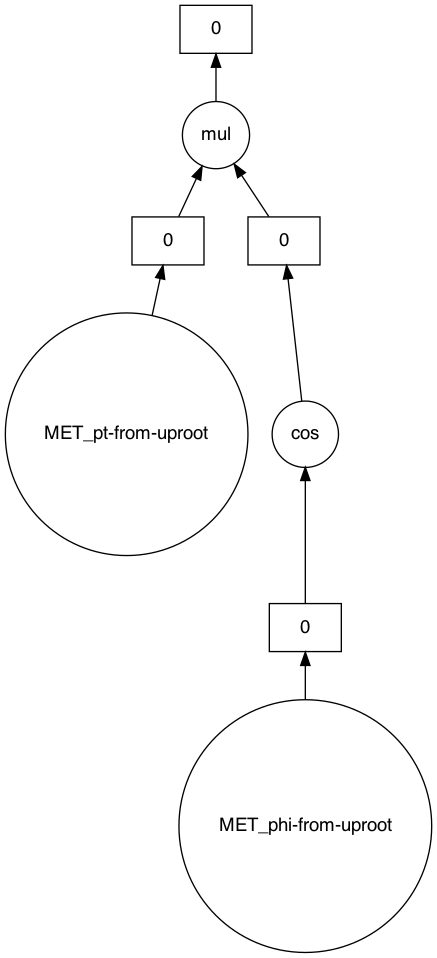

In [32]:
delayed_px.visualize()

In [33]:
delayed_px.compute()

array([-20.099522 , -16.336037 , -10.694641 , ...,  -5.527917 ,
        -9.405147 ,  -1.0401623], dtype=float32)

<br><br><br><br><br>

### Awkward Array

<img src="../img/awkward-logo.svg" width="300">

Awkward Array is a library for manipluating arrays of arbitrary data types as though they were NumPy arrays.

See [awkward-array.org](https://awkward-array.org/) for tutorials and reference documentation.


In [34]:
import awkward as ak

<br><br><br><br><br>

As an example with some generality, consider arrays of variable-length lists of records with fields "x" and "y"; the "x" values are either missing (`None`) or floating point values; the "y" are lists of integers.

Like this:

In [35]:
array = ak.Array([
    [{"x": 1.1, "y": [1]}, {"x": None, "y": [1, 2]}, {"x": 3.3, "y": [1, 2, 3]}],
    [],
    [{"x": None, "y": [1, 2, 3, 4]}, {"x": 5.5, "y": [1, 2, 3, 4, 5]}]
] * 10000)

The following NumPy-like expression

   * accesses field "y"
   * drops the first element of each list (`1:`) from the innermost dimension (`...`)
   * squares each value with `np.square`, a NumPy function
   * returns a structure that is unmodified from the original, except where dictated.

In [36]:
output = np.square(array["y", ..., 1:])
output

<Array [[[], [4], [4, 9]], ..., [[...], ...]] type='30000 * var * var * int64'>

Looking at that in more detail:

In [37]:
output.show()

[[[], [4], [4, 9]],
 [],
 [[4, 9, 16], [4, 9, 16, 25]],
 [[], [4], [4, 9]],
 [],
 [[4, 9, 16], [4, 9, 16, 25]],
 [[], [4], [4, 9]],
 [],
 [[4, 9, 16], [4, 9, 16, 25]],
 [[], [4], [4, 9]],
 ...,
 [[], [4], [4, 9]],
 [],
 [[4, 9, 16], [4, 9, 16, 25]],
 [[], [4], [4, 9]],
 [],
 [[4, 9, 16], [4, 9, 16, 25]],
 [[], [4], [4, 9]],
 [],
 [[4, 9, 16], [4, 9, 16, 25]]]


<br><br><br><br><br>

To do the equivalent in Python, we'd have to write the following:

In [38]:
array_as_lists = array.tolist()

In [39]:
%%timeit

output = []
for sublist in array_as_lists:
    tmp1 = []
    for record in sublist:
        tmp2 = []
        for number in record["y"][1:]:
            tmp2.append(np.square(number))
        tmp1.append(tmp2)
    output.append(tmp1)

98.9 ms ± 3.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The array-oriented expression is faster, too.

In [ ]:
%%timeit

output = np.square(array["y", ..., 1:])

<br><br><br><br><br>

How about converting an Awkward Array to RDataFrame and back*?

(\* Thanks to Yana Osborne!)

In [ ]:
rdf2 = ak.to_rdataframe({"array": array})

In [ ]:
rdf3 = rdf2.Define("output", """
std::vector<std::vector<int64_t>> tmp1;

for (auto record : array) {
    std::vector<int64_t> tmp2;
    for (auto number : record.y()) {
        tmp2.push_back(number * number);
    }
    tmp1.push_back(tmp2);
}
return tmp1;
""")

In [ ]:
output = ak.from_rdataframe(rdf3, "output")
output

<br><br><br><br><br>

### Vector

<br>

<img src="../img/vector-logo.svg" width="300">

<br>

Vector is a library for manipluating arrays of Lorentz vectors (and 2D, 3D Euclidean vectors).

See [vector.readthedocs.io](https://vector.readthedocs.io/) for tutorials and reference documentation.

We'll use this to add vectors and compute masses without having to write the formulae by hand.

<br><br><br><br><br>

### hist

<img src="../img/hist-logo.svg" width="300">

Hist is a library for filling, manipulating, and plotting histograms.

See [hist.readthedocs.io](https://hist.readthedocs.io/) for tutorials and reference documentation.

We'll use this to plot distributions.

<br><br><br><br><br>

# Next stop: lecture part 3

Go to [lecture-part-3.ipynb](lecture-part-3.ipynb) for the third notebook.